# OpenMM Scalability Benchmark: Single vs Multi CPU and GPU
This notebook tests how simulation performance scales across different computational configurations:
- Single CPU
- Multi-core CPU
- Single GPU (CUDA)
- Multi GPU (CUDA, if supported)


In [2]:
from openmm.app import *
from openmm import *
from openmm.unit import *
import numpy as np
import time
import matplotlib.pyplot as plt


## Create a Simple Particle System
A Lennard-Jones fluid with 200 particles in a periodic box.

In [3]:
n_particles = 200
box_size = 4.0

system = System()
positions = Quantity(np.random.rand(n_particles, 3) * box_size, nanometers)
nonbonded = NonbondedForce()

for i in range(n_particles):
    system.addParticle(39.9 * amu)
    nonbonded.addParticle(0.0, 0.34, 0.238)

system.addForce(nonbonded)
system.setDefaultPeriodicBoxVectors(Vec3(box_size,0,0)*nanometers,
                                     Vec3(0,box_size,0)*nanometers,
                                     Vec3(0,0,box_size)*nanometers)


## Benchmarking Function for Platform + Property Variants

In [4]:
def benchmark(platform_name, properties=None, steps=1000):
    try:
        platform = Platform.getPlatformByName(platform_name)
        integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)
        simulation = Simulation(Topology(), system, integrator, platform, properties or {})
        simulation.context.setPositions(positions)
        simulation.context.setVelocitiesToTemperature(300*kelvin)

        start = time.time()
        simulation.step(steps)
        end = time.time()
        rate = steps / (end - start)
        print(f"{platform_name} {properties if properties else ''}: {rate:.2f} steps/sec")
        return f"{platform_name} {properties if properties else ''}", rate
    except Exception as e:
        print(f"Error on {platform_name} {properties}: {e}")
        return f"{platform_name} {properties if properties else ''}", 0


## Run Benchmarks for CPU and GPU Configurations

CPU {'Threads': '1'}: 10749.33 steps/sec
CPU {'Threads': '4'}: 5959.22 steps/sec
CPU {'Threads': '8'}: 3426.60 steps/sec
Error on CUDA {'DeviceIndex': '0', 'Precision': 'single'}: There is no registered Platform called "CUDA"
OpenCL {'DeviceIndex': '0', 'Precision': 'single'}: 108553.86 steps/sec


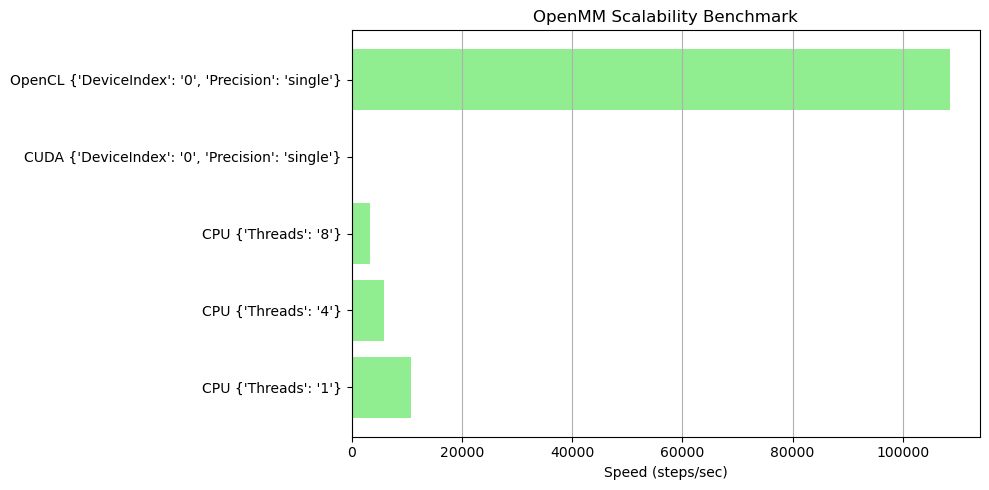

In [5]:
configs = [
    ("CPU", {"Threads": "1"}),
    ("CPU", {"Threads": "4"}),
    ("CPU", {"Threads": "8"}),
    ("CUDA", {"DeviceIndex": "0", "Precision": "single"}),
    ("OpenCL", {"DeviceIndex": "0", "Precision": "single"}),
]

results = [benchmark(name, props) for name, props in configs]

labels, speeds = zip(*results)
plt.figure(figsize=(10, 5))
plt.barh(labels, speeds, color='lightgreen')
plt.xlabel("Speed (steps/sec)")
plt.title("OpenMM Scalability Benchmark")
plt.grid(axis='x')
plt.tight_layout()
plt.show()
